In [2]:
import cv2 as cv 
import numpy as np 
import warnings as warn 
import pandas as pd 

from matplotlib import pyplot as plt 
from sklearn.cluster import KMeans
from tqdm import tqdm 

import os 
warn.simplefilter('ignore')

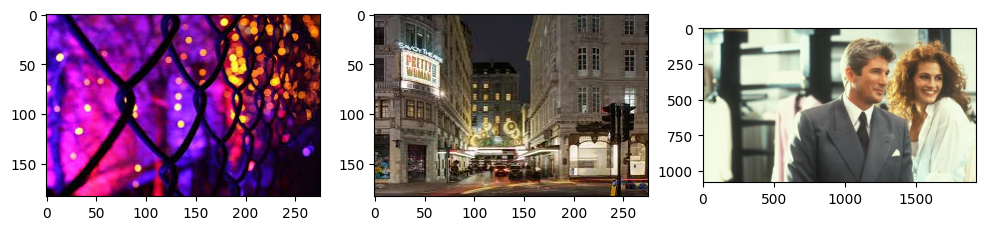

In [3]:
nets = cv.cvtColor(cv.imread('Images/Nets.jpeg'), cv.COLOR_BGR2RGB)
house = cv.cvtColor(cv.imread('Images/house.jpeg'), cv.COLOR_BGR2RGB)
person = cv.cvtColor(cv.imread('Images/Person.jpg'), cv.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(nets)

fig.add_subplot(1, 3, 2)
plt.imshow(house)

fig.add_subplot(1, 3, 3)
plt.imshow(person)

plt.show()


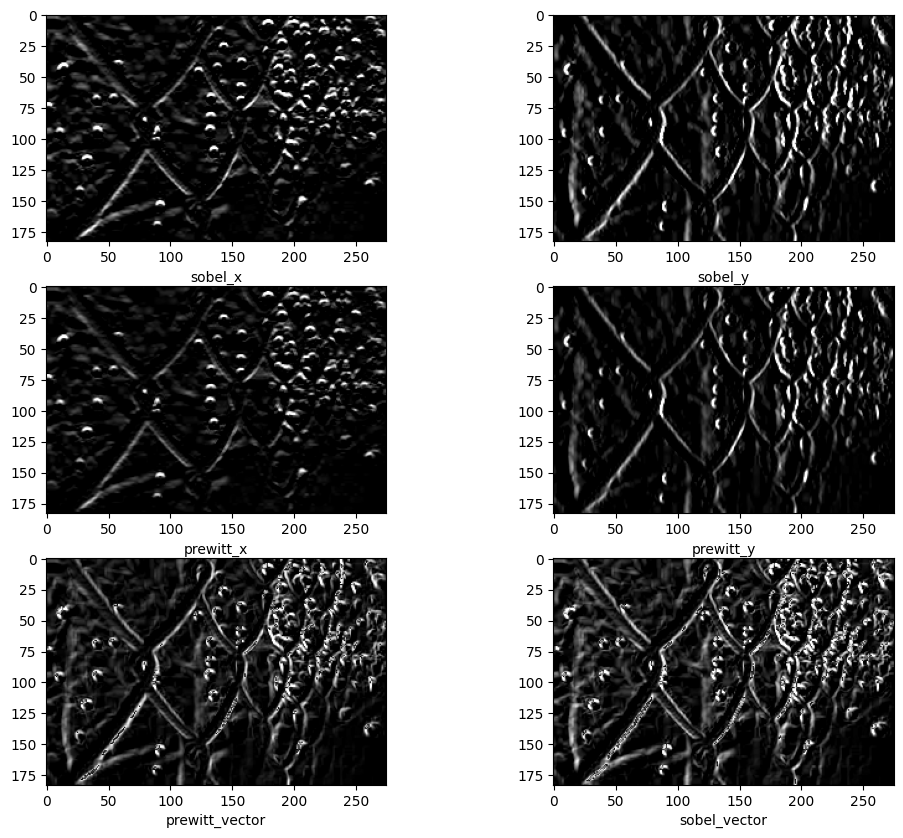

In [4]:
prewitt_x = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
prewitt_y = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

sobel_x = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
sobel_y = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

nets_gray = cv.cvtColor(nets, cv.COLOR_RGB2GRAY)

pnetx = cv.filter2D(nets_gray, -1, prewitt_x)
pnety = cv.filter2D(nets_gray, -1, prewitt_y)

snetx = cv.filter2D(nets_gray, -1, sobel_x)
snety = cv.filter2D(nets_gray, -1, sobel_y)

images = {
    'sobel_x':snetx, 
    'sobel_y':snety,
    'prewitt_x':pnetx, 
    'prewitt_y':pnety, 
    'prewitt_vector':pnetx + pnety, 
    'sobel_vector':snetx + snety, 
}

fig = plt.figure(figsize = (12, 10))
ind = 1
for label, img in images.items():
    fig.add_subplot(3, 2, ind)
    plt.imshow(img, cmap='gray')
    plt.xlabel(label)
    ind = ind + 1 

plt.show()


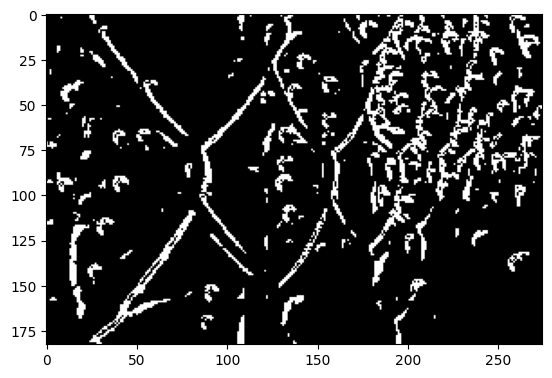

In [5]:
sobel_nets = snetx + snety 
prewitt_nets = pnetx + pnety 
_, threshold_nets = cv.threshold(prewitt_nets, 80, 255,  cv.THRESH_BINARY)
plt.imshow(threshold_nets, cmap='gray')

In [6]:
threshold_nets

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

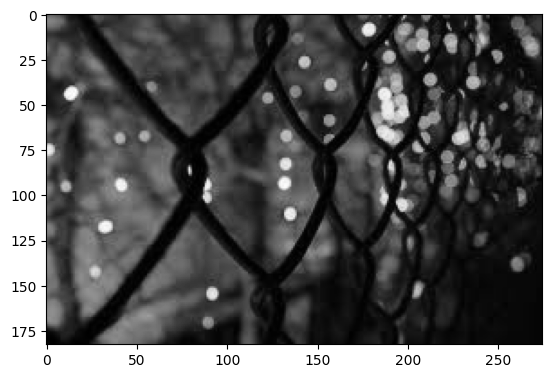

In [7]:
plt.imshow(nets_gray, cmap='gray')

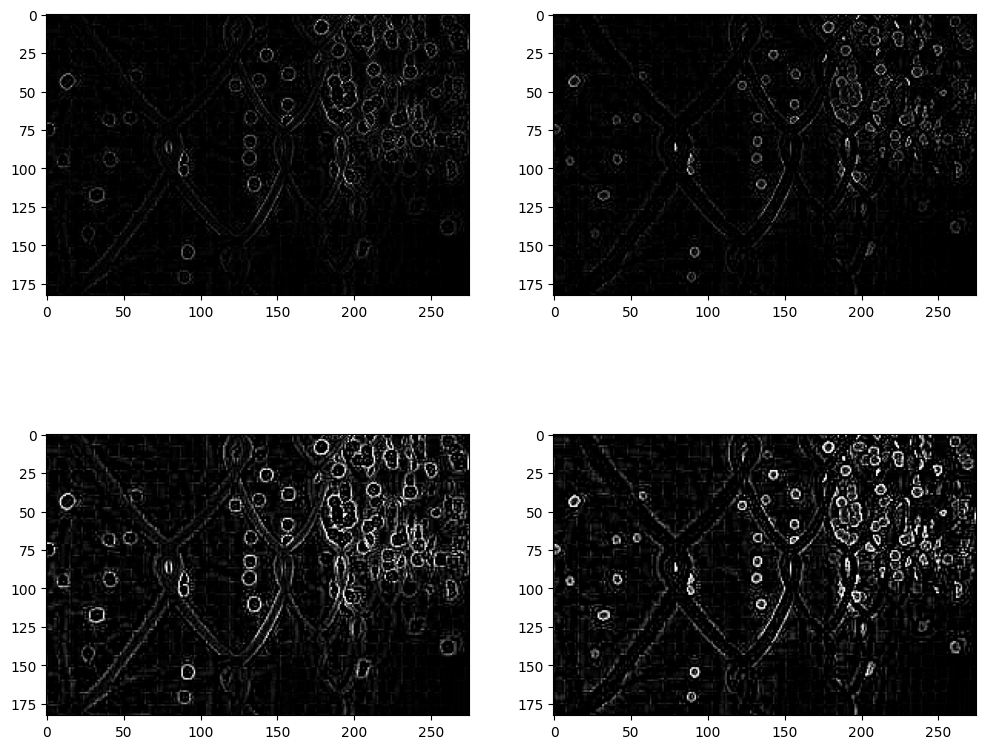

In [8]:
lap1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
lap2 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
lap3 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
lap4 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

fig = plt.figure(figsize=(12, 10))
for ind, kernel in enumerate([lap1, lap2, lap3, lap4]):
    fig.add_subplot(2, 2, ind+1)
    chains = cv.filter2D(nets_gray, -1, kernel)
    plt.imshow(chains, cmap='gray')

plt.show()

In [9]:
def disintegrate(image: np.array):
    rows, cols, dims = image.shape 
    dataset = []
    for i in tqdm(range(rows)):
        for j in range(cols):
            dataset.append(image[i, j, :])
    
    return pd.DataFrame(dataset, columns = ['R', 'G', 'B'])

nets_df = disintegrate(nets)


nets_df

100%|██████████| 183/183 [00:00<00:00, 10205.93it/s]


R   G    B
0      152  32  252
1      154  32  253
2      156  31  255
3      154  29  255
4      148  27  255
...    ...  ..  ...
50320    9   4   11
50321    8   3   10
50322    9   2   10
50323    9   2   10
50324    9   2   10

[50325 rows x 3 columns]

In [10]:
model = KMeans(n_clusters=5)
model.fit(nets_df)
classes = model.predict(nets_df)
pd.Series(classes).value_counts()

1    20419
4    11761
2     9973
3     6025
0     2147
Name: count, dtype: int64

0         Axes(0.1,0.679412;0.363636x0.220588)
1    Axes(0.536364,0.679412;0.363636x0.220588)
2         Axes(0.1,0.414706;0.363636x0.220588)
3    Axes(0.536364,0.414706;0.363636x0.220588)
4             Axes(0.1,0.15;0.363636x0.220588)
dtype: object

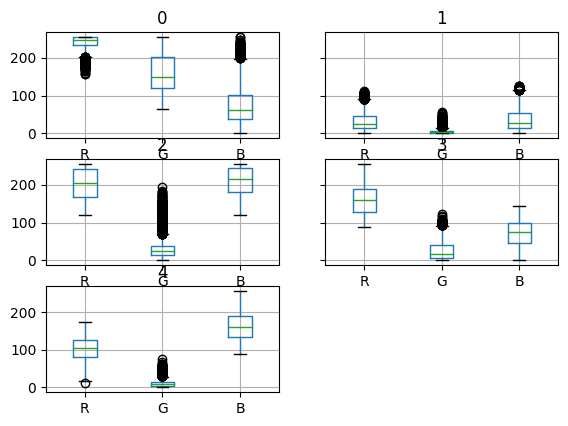

In [11]:
nets_df['CLASS'] = classes 
nets_df.groupby('CLASS')[['R', 'G', 'B']].boxplot()

In [12]:
nets_df1 = nets_df.drop(columns=['CLASS'])
def elbow(df):
    model_col = {}
    for i in range(2, 12):
        model = KMeans(n_clusters=i)
        model.fit(df)
        model_col[i] = {'inertia':model.inertia_, 'model': model}
    
    return model_col

models = elbow(nets_df1)
models


    

{2: {'inertia': 297132000.8426647, 'model': KMeans(n_clusters=2)},
 3: {'inertia': 211514703.57215968, 'model': KMeans(n_clusters=3)},
 4: {'inertia': 152999361.60486263, 'model': KMeans(n_clusters=4)},
 5: {'inertia': 123283040.78168848, 'model': KMeans(n_clusters=5)},
 6: {'inertia': 99689959.69367635, 'model': KMeans(n_clusters=6)},
 7: {'inertia': 87409256.837499, 'model': KMeans(n_clusters=7)},
 8: {'inertia': 76102103.80178654, 'model': KMeans()},
 9: {'inertia': 68945160.80872574, 'model': KMeans(n_clusters=9)},
 10: {'inertia': 63290818.313104644, 'model': KMeans(n_clusters=10)},
 11: {'inertia': 57878383.17893257, 'model': KMeans(n_clusters=11)}}

In [13]:
nets.reshape(-1, 3)

array([[152,  32, 252],
       [154,  32, 253],
       [156,  31, 255],
       ...,
       [  9,   2,  10],
       [  9,   2,  10],
       [  9,   2,  10]], dtype=uint8)

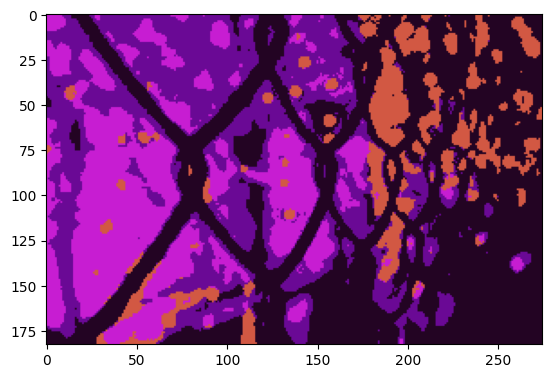

In [14]:
model = models[4]['model']
image = np.uint8(model.cluster_centers_[model.labels_].reshape(nets.shape)) 
plt.imshow(image)
plt.show()


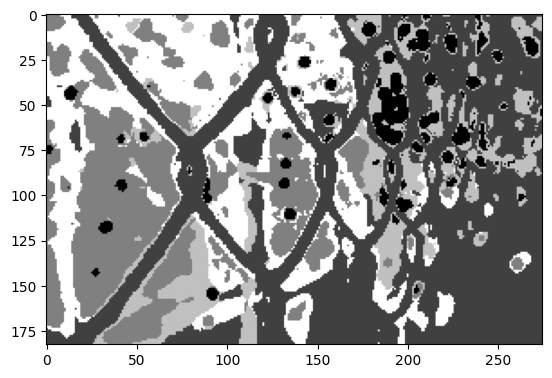

In [15]:
net_segment = classes.reshape(nets.shape[0], nets.shape[1])
plt.imshow(net_segment, cmap='gray') 
plt.show()

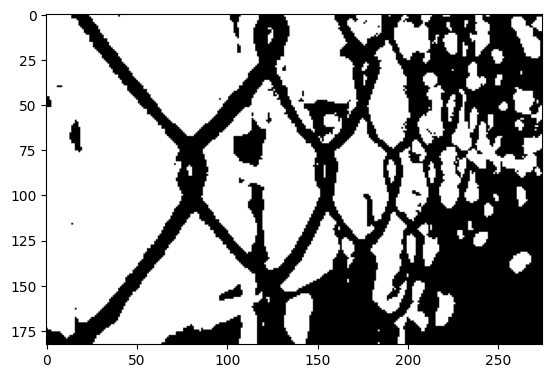

In [16]:
chain = np.where(net_segment == 1, 0, 1)
plt.imshow(chain, cmap='gray')
plt.show()

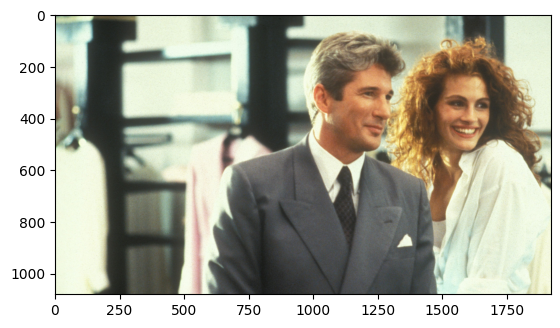

In [19]:
plt.imshow(person)
plt.show()

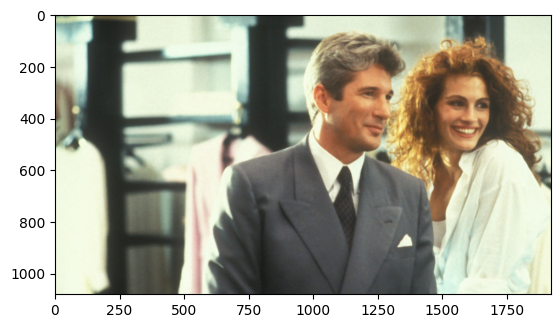

In [23]:
cleared = cv.medianBlur(person, 5, None)
plt.imshow(cleared)

In [24]:
person.shape

(1080, 1920, 3)

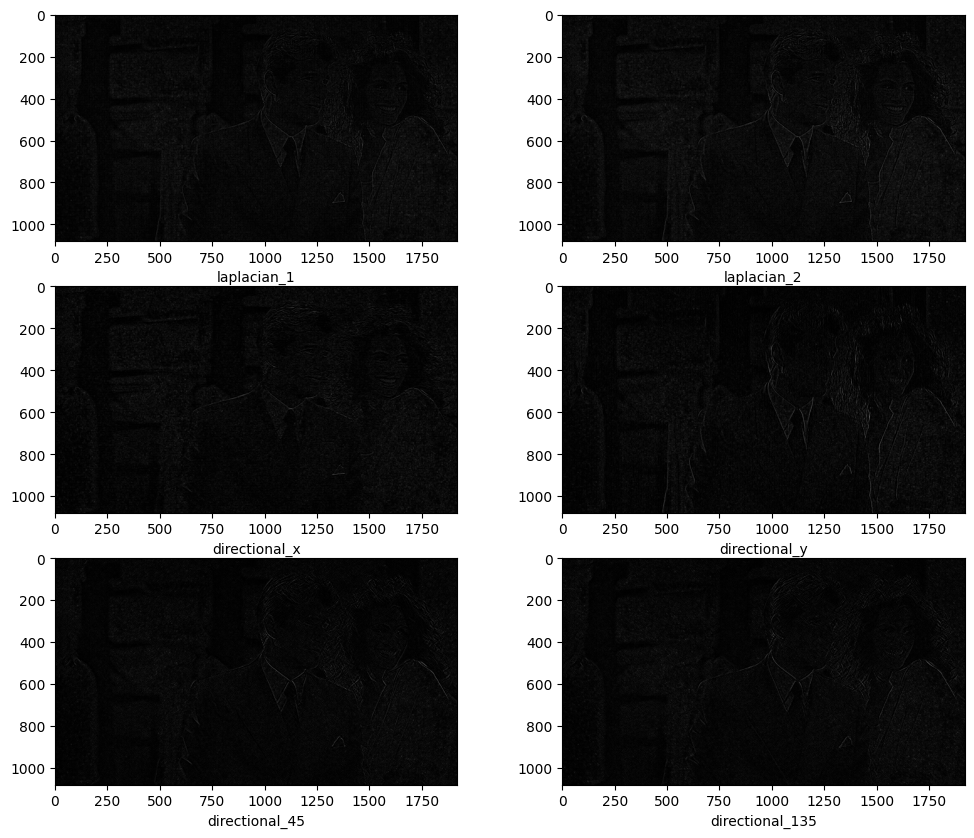

In [33]:
def detect_lines(img, gray = False):
    kernels = {
        "laplacian_1":np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]), 
        "laplacian_2":np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]), 
        "directional_x":np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]]), 
        "directional_y":np.array([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]]), 
        "directional_45":np.array([[2, -1, -1], [-1, 2, -1], [-1, -1, 2]]), 
        "directional_135":np.array([[-1, -1, 2], [-1, 2, -1], [2, -1, -1]]), 
    }
    ind = 1 
    fig = plt.figure(figsize=(12, 10))
    for name, kernel in kernels.items():
        filtered_img = cv.filter2D(img, -1, kernel, None)
        fig.add_subplot(3, 2, ind)
        ind += 1 
        plt.xlabel(name)
        if gray: plt.imshow(filtered_img, cmap='gray') 
        else: plt.imshow(filtered_img)

    plt.show()

person_gray = cv.cvtColor(person, cv.COLOR_RGB2GRAY)

detect_lines(person_gray, True)
    


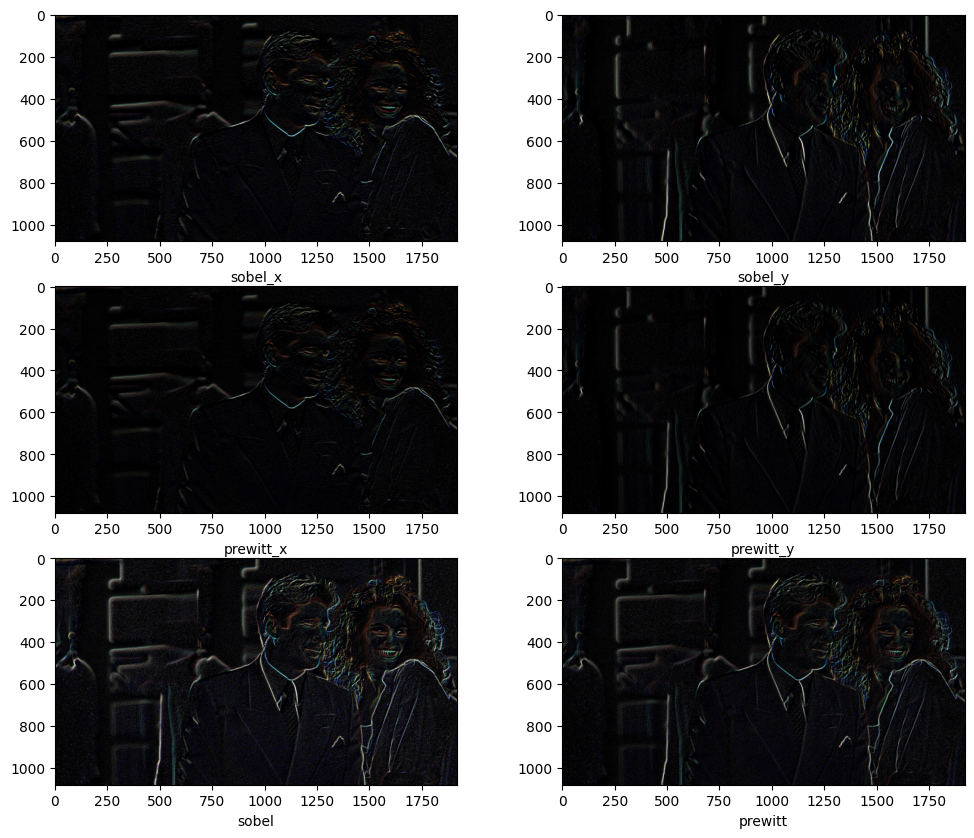

In [38]:
def detect_edges(img, gray = False):
    kernels = {
        "sobel_x":np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]), 
        "sobel_y":np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]), 
        "prewitt_x":np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]), 
        "prewitt_y":np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]),
    }

    images = {}

    ind = 1 
   
    for name, kernel in kernels.items():
        filtered_img = cv.filter2D(img, -1, kernel, None)
        images[name] = filtered_img

    images['sobel'] = images['sobel_x'] + images['sobel_y']
    images['prewitt'] = images['prewitt_x'] + images['prewitt_y']
    
    fig = plt.figure(figsize= (12, 10))
    for name, image in images.items():
        fig.add_subplot(3, 2, ind)
        if gray: plt.imshow(image, cmap = 'gray')
        else: plt.imshow(image)
        plt.xlabel(name)
        ind += 1

    plt.show()



detect_edges(person)